## spice Workshop - Experiments

In this notebook, we explore data and experiment iteratively.

In [1]:
import logging

logging.disable()


2 datasets are used:
- TLC NYC Taxi trips (2015) - [link](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)
- NOAA Climate data of JFK airport, NYC (2015) - [link](https://www.ncei.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094789/detail)

### TLC NYC Taxi trips
Contains taxi trips, whose duration we seek to predict.
<br><br>

| Column name | Description |
| :- | :- |
| vendor_id | TPEP provider that provided the record |
| pickup_datetime | The start date of the ride |
| dropoff_datetime | The end date of the ride |
| passenger_count | Number of passenger |
| trip_distance | The distance in Mile of the ride |
| pickup_longitude | The longitude of starting point of the ride |
| pickup_latitude | The latitude of starting point of the ride |
| rate_code | The rate code |
| store_and_fwd_flag | Trip record held in vehicle memory before sending to the vendor |
| dropoff_longitude | The longitude of end point of the ride |
| dropoff_latitude | The longitude of end point of the ride |
| payment_type | Type of payment |
| fare_amount | Amount of the ride in dollars |

More details on data schema on the [NYC TLC website](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)


### NOAA Climate data of JFK airport, NYC
Contains weather information.
Most 'important' columns are:
<br><br>

| Column name | Description |
| :- | :- |
| TMAX | Maximum temperature |
| TMIN | Minimum temperature |
| PRCP | Precipitation |
| SNOW | Snowfall |
| SNWD | Snow depth |
| ACMH | Average cloudiness midnight to midnight |
| TSUN | Total sunshine for the period |
| AWND | Average wind speed |

Full data schema is available on the [NOAA website](https://www.ncei.noaa.gov/cdo-web/datasets/GHCND/stations/GHCND:USW00094789/detail)


In [2]:
from src.data import get_train_dataset

data = get_train_dataset()


In [3]:
import ydata_profiling

ydata_profiling.ProfileReport(data).to_widgets()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
from src.data import get_target

target = get_target(data)
target.head()


0    2104
1    1671
2    1782
3    1624
4    2225
Name: trip_duration, dtype: int32

In [5]:
from sklearn.model_selection import train_test_split

from src.schemas import TaxiColumn
from src.config import config

train_idx, test_idx = train_test_split(
    data.sort_values(TaxiColumn.PICKUP_TIME).index,
    test_size=config.test_size,
    shuffle=False,
)
train_idx, test_idx


(Index([13463, 19816, 16230, 12497, 14337,   633, 17495, 13345,  5484, 12539,
        ...
        16109, 16399, 14494, 11029,  7376, 12774,  1893,  5294,  3669, 19053],
       dtype='int64', length=13773),
 Index([ 9765, 13963, 18472,  8481,  2208,  6891, 19760, 13609, 13852,  4819,
        ...
         2838, 19369,  8797,  2248,  8388,  9021, 20264, 12163,  1224,  9300],
       dtype='int64', length=6784))

In [6]:
COLS_TO_EXTRACT = [
    TaxiColumn.VENDOR_ID,
    TaxiColumn.PASSENGER_COUNT,
    TaxiColumn.PICKUP_LON,
    TaxiColumn.PICKUP_LAT,
    TaxiColumn.DROPOFF_LON,
    TaxiColumn.DROPOFF_LAT,
]

features = data.loc[:, COLS_TO_EXTRACT]
features.head()


,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,1,1,-73.974998,40.756504,-73.872536,40.774345
1,2,5,-74.001587,40.741020,-73.955109,40.685692
2,2,1,-73.863098,40.769184,-73.964119,40.679508
3,2,1,-73.995331,40.725002,-73.932930,40.665352
4,1,1,-73.953484,40.772774,-73.776382,40.645233


In [7]:
train_features, train_target = features.iloc[train_idx], target.iloc[train_idx]
test_features, test_target = features.iloc[test_idx], target.iloc[test_idx]


In [8]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor().fit(train_features, train_target)


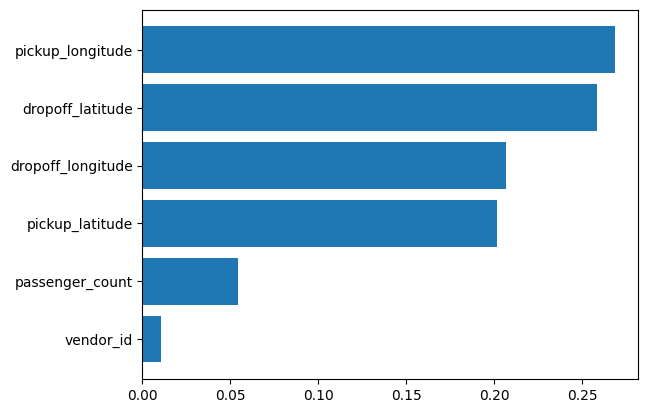

In [9]:
%matplotlib inline

from matplotlib import pyplot as plt

sorted_idx = model.feature_importances_.argsort()

plt.barh(model.feature_names_in_[sorted_idx], model.feature_importances_[sorted_idx])
plt.show()


In [10]:
import numpy as np
from sklearn.linear_model import Lasso

dropped = set()
for alpha in np.arange(1, 100, 1):
    lasso = Lasso(alpha=alpha).fit(train_features, train_target)

    indices = np.where(lasso.coef_ == 0)[0]
    if new_missing := {
        feature for feature in lasso.feature_names_in_[indices]
        if not feature in dropped
    }:
        print(f"{new_missing} has coef 0 at alpha = {alpha}")
        dropped |= new_missing


/Users/lucasleray/Documents/nibble/spice-workshop/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.424e+10, tolerance: 8.243e+06
  model = cd_fast.enet_coordinate_descent(
/Users/lucasleray/Documents/nibble/spice-workshop/.venv/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.212e+09, tolerance: 8.243e+06
  model = cd_fast.enet_coordinate_descent(


{'pickup_latitude'} has coef 0 at alpha = 2
{'dropoff_latitude'} has coef 0 at alpha = 3
{'vendor_id'} has coef 0 at alpha = 24
{'passenger_count'} has coef 0 at alpha = 63


In [11]:
import pandas as pd
from sklearn.model_selection import cross_validate

SCORING_METHODS = (
    'neg_mean_absolute_error',
    'neg_mean_squared_error',
)

model = RandomForestRegressor(random_state=42)
cv_scores = cross_validate(model, features, target, scoring=SCORING_METHODS, cv=5)


In [12]:
pd.DataFrame(cv_scores).agg(['mean', 'std'])


,fit_time,score_time,test_neg_mean_absolute_error,test_neg_mean_squared_error
mean,5.102951,0.080471,-629.135585,-7.812880e+06
std,0.092466,0.002146,28.518070,2.833745e+06
